In [ ]:
!pip install -r requirements.txt

Data Loaded. Features: ['Genre_Code', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Running K-Means... Done (0.7885s)
Running Hierarchical... Done (0.0034s)
Running DBSCAN... Done (0.2273s)
Running GMM... Done (0.5364s)

FINAL COMPARISON SUMMARY
         Method  Time (s)         Params  Silhouette
0       K-Means  0.788515            K=4    0.298397
1  Hierarchical  0.003442            K=2    0.241780
2        DBSCAN  0.227319  eps=1.1, ms=3    0.277604
3           GMM  0.536372      N=5, diag    0.272993


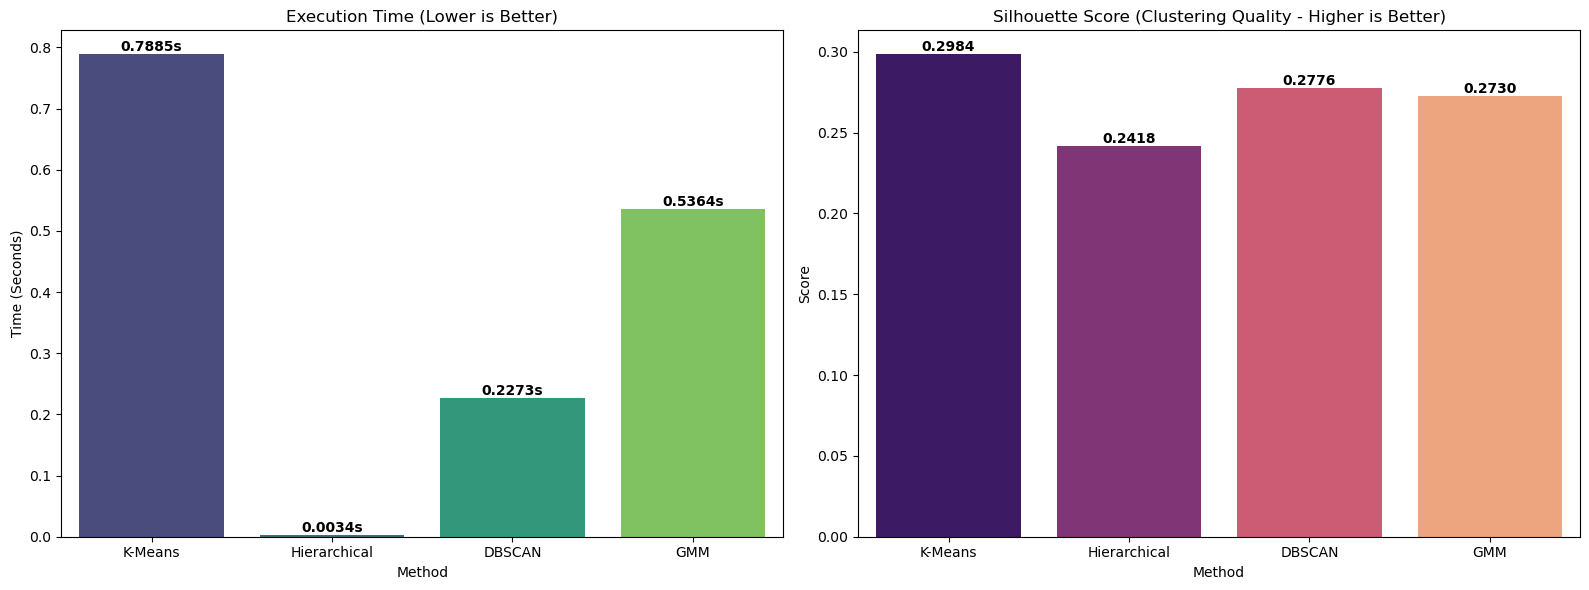

In [3]:
import os
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['LOKY_MAX_CPU_COUNT'] = '1'
warnings.filterwarnings('ignore')

def find_knee_point(x, y):
    # Normalize data for geometric distance calc
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    
    # Line connecting first and last point
    x1, y1 = x_norm[0], y_norm[0]
    x2, y2 = x_norm[-1], y_norm[-1]
    
    distances = []
    for i in range(len(x)):
        x0, y0 = x_norm[i], y_norm[i]
        # Perpendicular distance formula
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator / denominator)
        
    return x[np.argmax(distances)]

def get_k_from_dendrogram(X_data, method='ward'):
    Z = sch.linkage(X_data, method=method)
    last_distances = Z[-15:, 2]
    last_distances_sorted = np.sort(last_distances)[::-1]
    gaps = np.diff(last_distances_sorted)
    max_gap_index = np.argmin(gaps)
    optimal_k = max_gap_index + 2
    return optimal_k

df = pd.read_csv('Mall_Customers.csv')
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])
features = ['Genre_Code', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X_scaled = StandardScaler().fit_transform(df[features])

print(f"Data Loaded. Features: {features}\n")
results = []

# --- 1. K-Means ---
print("Running K-Means...", end=" ")
start = time.time()
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10).fit(X_scaled)
    wcss.append(kmeans.inertia_)
best_k_kmeans = find_knee_point(np.array(K_range), np.array(wcss))
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10).fit(X_scaled)
time_kmeans = time.time() - start
score_kmeans = silhouette_score(X_scaled, kmeans.labels_)
results.append({'Method': 'K-Means', 'Time (s)': time_kmeans, 'Params': f'K={best_k_kmeans}', 'Silhouette': score_kmeans})
print(f"Done ({time_kmeans:.4f}s)")

# --- 2. Hierarchical ---
print("Running Hierarchical...", end=" ")
start = time.time()
best_k_hc = get_k_from_dendrogram(X_scaled)
hc = AgglomerativeClustering(n_clusters=best_k_hc, linkage='ward').fit(X_scaled)
time_hc = time.time() - start
score_hc = silhouette_score(X_scaled, hc.labels_)
results.append({'Method': 'Hierarchical', 'Time (s)': time_hc, 'Params': f'K={best_k_hc}', 'Silhouette': score_hc})
print(f"Done ({time_hc:.4f}s)")

# --- 3. DBSCAN (Grid Search) ---
print("Running DBSCAN...", end=" ")
start = time.time()
best_score_db = -1
best_params_db = ('N/A', 'N/A')
eps_range = np.arange(0.3, 1.5, 0.1)
min_samples_range = range(3, 10)
for eps in eps_range:
    for ms in min_samples_range:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        if len(np.unique(labels)) > 1:
            try:
                score = silhouette_score(X_scaled, labels)
                if score > best_score_db:
                    best_score_db = score
                    best_params_db = (eps, ms)
            except: pass
time_db = time.time() - start
results.append({'Method': 'DBSCAN', 'Time (s)': time_db, 'Params': f'eps={best_params_db[0]:.1f}, ms={best_params_db[1]}', 'Silhouette': best_score_db})
print(f"Done ({time_db:.4f}s)")

# --- 4. GMM (Grid Search) ---
print("Running GMM...", end=" ")
start = time.time()
best_bic = np.inf
best_gmm_params = ('N/A', 'N/A')
best_labels_gmm = None
for n in range(2, 11):
    for cv in ['full', 'tied', 'diag', 'spherical']:
        try:
            gmm = GaussianMixture(n_components=n, covariance_type=cv, random_state=42).fit(X_scaled)
            bic = gmm.bic(X_scaled)
            if bic < best_bic:
                best_bic = bic
                best_gmm_params = (n, cv)
                best_labels_gmm = gmm.predict(X_scaled)
        except: pass
time_gmm = time.time() - start
if best_labels_gmm is not None:
    score_gmm = silhouette_score(X_scaled, best_labels_gmm)
else: 
    score_gmm = 0
results.append({'Method': 'GMM', 'Time (s)': time_gmm, 'Params': f'N={best_gmm_params[0]}, {best_gmm_params[1]}', 'Silhouette': score_gmm})
print(f"Done ({time_gmm:.4f}s)")

# Summary
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("FINAL COMPARISON SUMMARY")
print("="*50)
print(results_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Time
sns.barplot(x='Method', y='Time (s)', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('Execution Time (Lower is Better)')
axes[0].set_ylabel('Time (Seconds)')
for i, v in enumerate(results_df['Time (s)']):
    axes[0].text(i, v, f"{v:.4f}s", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Silhouette Score
sns.barplot(x='Method', y='Silhouette', data=results_df, ax=axes[1], palette='magma')
axes[1].set_title('Silhouette Score (Clustering Quality - Higher is Better)')
axes[1].set_ylabel('Score')
for i, v in enumerate(results_df['Silhouette']):
    axes[1].text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()